In [10]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import WD_models
from wdphoto import LaPlataInterpolator, WarwickDAInterpolator, PhotometryEngine, deredden

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

In [11]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [12]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u

In [13]:
from astropy.table import Table, vstack, unique

catalog = Table.read('data/00_base_catalog.fits')

catalog['wd_phot_g_mean_flux'] = catalog['wd_phot_g_mean_flux'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
catalog['wd_phot_bp_mean_flux'] = catalog['wd_phot_bp_mean_flux'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
catalog['wd_phot_rp_mean_flux'] = catalog['wd_phot_rp_mean_flux'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

catalog['wd_phot_g_mean_flux_error'] = catalog['wd_phot_g_mean_flux_error'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
catalog['wd_phot_bp_mean_flux_error'] = catalog['wd_phot_bp_mean_flux_error'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
catalog['wd_phot_rp_mean_flux_error'] = catalog['wd_phot_rp_mean_flux_error'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

catalog['wd_e_gmag'] = catalog['wd_phot_g_mean_flux_error'] / (1.09 * catalog['wd_phot_g_mean_flux'])
catalog['wd_e_bpmag'] = catalog['wd_phot_bp_mean_flux_error'] / (1.09 * catalog['wd_phot_bp_mean_flux'])
catalog['wd_e_rpmag'] = catalog['wd_phot_rp_mean_flux_error'] / (1.09 * catalog['wd_phot_rp_mean_flux'])

In [14]:
from astropy.table import Table, vstack, hstack

only_rvs = True

stardats = []
iters = (len(catalog)+1000) // 1000

# MS Gaia Sources

for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['ms_source_id'][1000*i:1000*i+1000]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)
gaia_d1.rename_column('source_id', 'ms_source_id')
catalog = join(catalog, gaia_d1, keys = 'ms_source_id')

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


In [15]:
from dustmaps.edenhofer2023 import Edenhofer2023Query

photo = np.array([catalog['wd_phot_g_mean_mag'], catalog['wd_phot_bp_mean_mag'], catalog['wd_phot_rp_mean_mag']]).T

# Query Edenhofer2023 to get E(B-V) in arbitrary units
#bsq = Edenhofer2023Query()
#gaia_g, gaia_bp, gaia_rp = deredden(bsq, catalog['wd_l'], catalog['wd_b'], photo, catalog['r_med_geo'], ['Gaia_G', 'Gaia_BP', 'Gaia_RP'])
#catalog['wd_phot_g_mean_mag_ext'], catalog['wd_phot_bp_mean_mag_ext'], catalog['wd_phot_rp_mean_mag_ext'] = gaia_g, gaia_bp, gaia_rp

In [16]:
bands = ['Gaia_BP', 'Gaia_RP']

warwick_interpolator = WarwickDAInterpolator(bands = bands, precache=True)

co_hrich = LaPlataInterpolator('CO', 'Hrich', '0_02', bands, logg_lims = (8.95, 9.15))
co_hdef = LaPlataInterpolator('CO', 'Hdef', '0_02', bands, logg_lims = (8.95, 9.15))
one_hrich = LaPlataInterpolator('ONe', 'Hrich', '0_02', bands, logg_lims = (8.95, 9.15))
one_hdef = LaPlataInterpolator('ONe', 'Hdef', '0_02', bands, logg_lims = (8.95, 9.15))

WarwickEngine = PhotometryEngine(warwick_interpolator)
CO_HrichEngine = PhotometryEngine(co_hrich)
CO_HdefEngine = PhotometryEngine(co_hdef)
ONe_HrichEngine = PhotometryEngine(one_hrich)
ONe_HdefEngine = PhotometryEngine(one_hdef)

In [17]:
obs_mag = catalog[['wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag']]
e_obs_mag = catalog[['wd_e_bpmag', 'wd_e_rpmag']]
distances = catalog['r_med_geo']

CO_HrichEngine(obs_mag[0], e_obs_mag[0], distances[0])

(0.006603367361522474,
 9.819019027714624e-07,
 11492.287701791458,
 1.4854777374233308,
 8.95,
 0,
 1.5982424678301593e-14)

In [18]:
outs = np.nan*np.zeros((5, len(obs_mag), 7))

for i in tqdm(range(len(obs_mag))):
    outs[0,i] = WarwickEngine(obs_mag[i], e_obs_mag[i], distances[i])
    outs[1,i] = CO_HrichEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])
    outs[2,i] = CO_HdefEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])
    outs[3,i] = ONe_HrichEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])
    outs[4,i] = ONe_HdefEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])

100%|██████████| 317/317 [00:58<00:00,  5.43it/s]


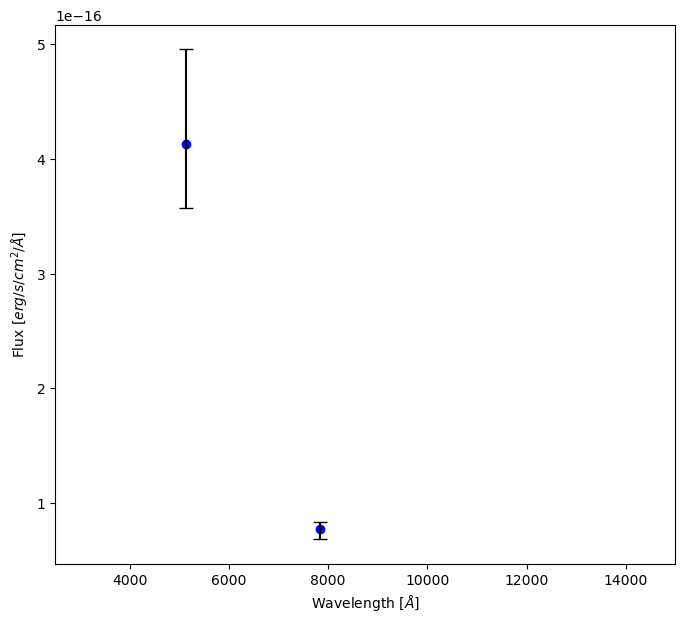

In [43]:
import wdphoto

i = 43
j = 0

engines = [WarwickEngine, CO_HrichEngine, CO_HdefEngine, ONe_HrichEngine, ONe_HdefEngine]

wdphoto.utils.plot(obs_mag[i], e_obs_mag[i], distances[i], outs[j,i,0], outs[j,i,2], outs[j,i,4], engines[j])

Text(0, 0.5, 'ONe_Hdef')

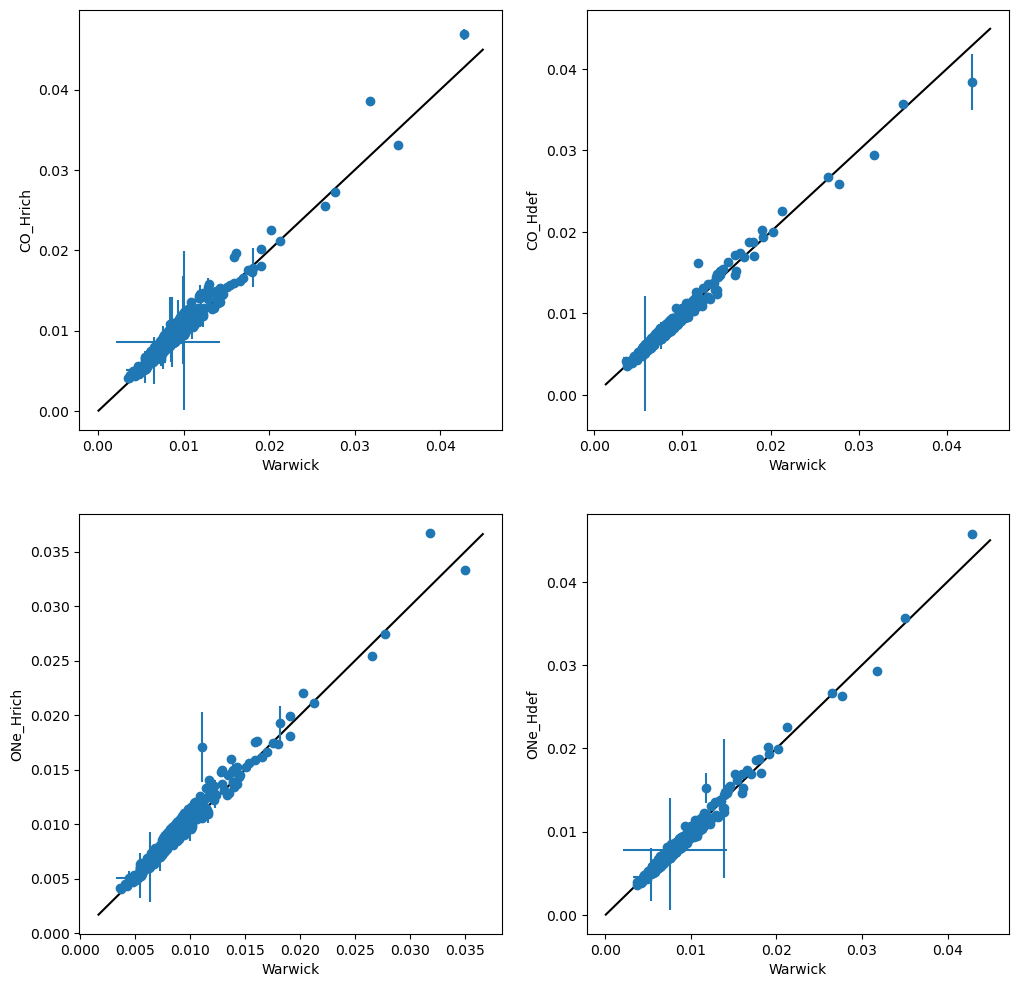

In [30]:
mask = np.all([outs[0,:,1] < 0.01, outs[1,:,1] < 0.01], axis=0)

plt.figure(figsize=(12,12))

plt.subplot(221)
plt.errorbar(outs[0,:,0][mask], outs[1,:,0][mask], xerr = outs[0,:,1][mask], yerr = outs[1,:,1][mask], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Warwick')
plt.ylabel('CO_Hrich')

mask = np.all([outs[0,:,1] < 0.01, outs[2,:,1] < 0.01], axis=0)

plt.subplot(222)
plt.errorbar(outs[0,:,0][mask], outs[2,:,0][mask], xerr = outs[0,:,1][mask], yerr = outs[2,:,1][mask], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Warwick')
plt.ylabel('CO_Hdef')

mask = np.all([outs[0,:,1] < 0.01, outs[3,:,1] < 0.01], axis=0)

plt.subplot(223)
plt.errorbar(outs[0,:,0][mask], outs[3,:,0][mask], xerr = outs[0,:,1][mask], yerr = outs[3,:,1][mask], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Warwick')
plt.ylabel('ONe_Hrich')

mask = np.all([outs[0,:,1] < 0.01, outs[4,:,1] < 0.01], axis=0)

plt.subplot(224)
plt.errorbar(outs[0,:,0][mask], outs[4,:,0][mask], xerr = outs[0,:,1][mask], yerr = outs[4,:,1][mask], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Warwick')
plt.ylabel('ONe_Hdef')


(array([ 7., 17., 42., 50., 63., 37., 32., 16., 16.,  5., 10.,  4.,  4.,
         2.,  3.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.0035464 , 0.00452862, 0.00551085, 0.00649307, 0.00747529,
        0.00845751, 0.00943973, 0.01042195, 0.01140417, 0.0123864 ,
        0.01336862, 0.01435084, 0.01533306, 0.01631528, 0.0172975 ,
        0.01827972, 0.01926195, 0.02024417, 0.02122639, 0.02220861,
        0.02319083, 0.02417305, 0.02515527, 0.0261375 , 0.02711972,
        0.02810194, 0.02908416, 0.03006638, 0.0310486 , 0.03203082,
        0.03301305, 0.03399527, 0.03497749, 0.03595971, 0.03694193,
        0.03792415, 0.03890637, 0.0398886 , 0.04087082, 0.04185304,
        0.04283526]),
 <BarContainer object of 40 artists>)

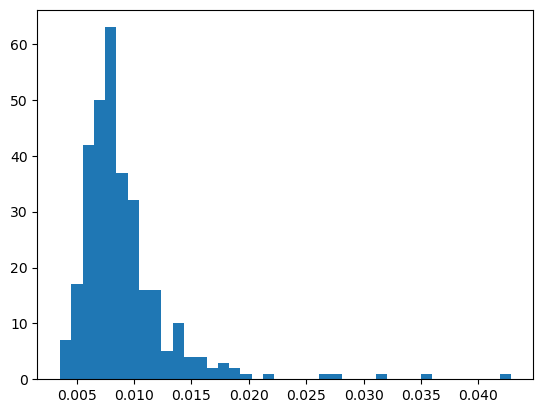

In [48]:
plt.hist(outs[0,:,0], bins=40)

In [45]:
outs[0,43,0]

0.012222585872450868